In [1]:
%matplotlib inline

import os.path as fs
from PIL import Image
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy.io
from datetime import datetime, timedelta

try:
    import cPickle as pickle
except:
    import pickle

DATA_DIR = '../data'

WIKI_CROPS_DIR = "wiki_crop"
IMDB_CROPS_DIR = "imdb_crop"

WIKI_META_FILE = '%s/wiki.mat' % WIKI_CROPS_DIR
IMDB_META_FILE = 'imdb/imdb.mat'

WIKI_META_OBJ = 'wiki_meta.obj'
IMDB_META_OBJ = 'imdb_meta.obj'

In [2]:
lmap = lambda f, l: list(map(f, l))
lfilter = lambda f, l: list(filter(f, l))

def python_datetime(x):
    try:
        return datetime.fromordinal(int(x)) + timedelta(days=int(x)%1) - timedelta(days = 366)
    except:
        return None

python_datetime_vec = np.vectorize(python_datetime)

get_year_vec = np.vectorize(lambda x: x.year if x is not None else 0)
to_string_vec = np.vectorize(lambda x: str(x)[2:-2])

def get_meta_data(filename, key='wiki'):
    # Read input file
    meta = scipy.io.loadmat(fs.join(DATA_DIR, filename))
      
    dob_timestamp = np.asarray(meta[key][0][0][0])
    photo_taken_year = np.asarray(meta[key][0][0][1])
    full_path = np.asarray(meta[key][0][0][2])
    gender = np.asarray(meta[key][0][0][3])
    name = np.asarray(meta[key][0][0][4])
    face_location = np.asarray(meta[key][0][0][5])
    face_score = np.asarray(meta[key][0][0][6])
    face_score_2 = np.asarray(meta[key][0][0][7])
    
    # Parse Matlab date
    dob_timestamp = python_datetime_vec(dob_timestamp[0,:])
    age = photo_taken_year[0,:] - get_year_vec(dob_timestamp)
    
    return {
        'path':   to_string_vec(full_path[0,:]),
        'name':   to_string_vec(name[0,:]),
        'age':    age,
        'gender': gender[0,:].astype(int)
    }

def filter_meta_data(data, filter_mask):
    return {
        'path':   data['path'][filter_mask],
        'name':   data['name'][filter_mask],
        'age':    data['age'][filter_mask],
        'gender': data['gender'][filter_mask]
    }

def to_bins(data, bins):
    bin_labels = lmap(lambda b: '%s-%s' % b, bins)
    
    bins.append((-1, -1))
    bin_labels.append('other')
    
    binarize = lambda x: bins.index(next(filter(lambda e: x >= e[0] and x <= e[1], bins), bins[-1]))
    binarize_vec = np.vectorize(binarize)
    return binarize_vec(data), bin_labels
    
def plot_histo(data, bins=30, range=(0,100), figsize=(20,10), xticks=None):
    hist, bin_edges = np.histogram(data, bins=bins, range=range)

    plt.figure(figsize=figsize)
    plt.bar(bin_edges[:-1], hist, width=1)
    plt.xlim(min(bin_edges), max(bin_edges))
    if xticks is not None:
        plt.xticks(np.arange(len(xticks)) + 0.5, xticks)
    plt.show()

In [3]:
def img_is_sane(path):
    with Image.open(path) as im:
        return im.size[0] > 1 and im.size[1] > 1

img_is_sane_vec = np.vectorize(img_is_sane)

## Analyse Wiki Dataset

In [4]:
if not fs.exists(fs.join(DATA_DIR, WIKI_META_OBJ)):
    # Load the dataset
    wiki_meta = get_meta_data(fs.join(DATA_DIR, WIKI_META_FILE), 'wiki')
    
    # Identify faulty images
    sanity_mask = img_is_sane_vec(list(map(lambda p: fs.join(DATA_DIR, WIKI_CROPS_DIR, p), wiki_meta['path'])))
    
    # We can assume that images with the dimensions (1,1) are faulty
    print('Faulty entries by img dimension: %i' % (len(sanity_mask) - np.sum(sanity_mask)))
    
    # Clean the data set
    wiki_meta = filter_meta_data(wiki_meta, sanity_mask)
    
    # We can assume that ages above 100 are faulty
    print('Faulty entries by age > 100: %i' % (np.sum(wiki_meta['age'] > 100)))
    print('Faulty entries by age < 0: %i' % (np.sum(wiki_meta['age'] < 0)))

    wiki_meta = filter_meta_data(wiki_meta, wiki_meta['age'] <= 100)
    wiki_meta = filter_meta_data(wiki_meta, wiki_meta['age'] >= 0)
    
    with open(fs.join(DATA_DIR, WIKI_META_OBJ), 'wb') as file:
        pickle.dump(wiki_meta, file)
else:
    with open(fs.join(DATA_DIR, WIKI_META_OBJ), 'rb') as file:
        wiki_meta = pickle.load(file)

Faulty entries by img dimension: 8070
Faulty entries by age > 100: 161
Faulty entries by age < 0: 1021


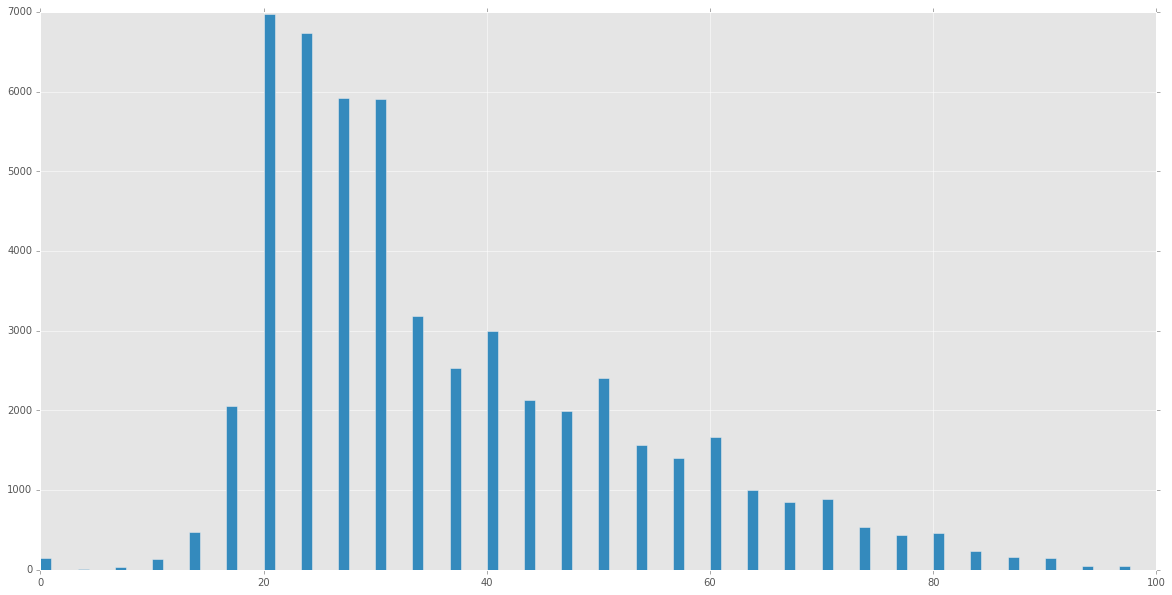

In [5]:
plot_histo(wiki_meta['age'], bins=30)

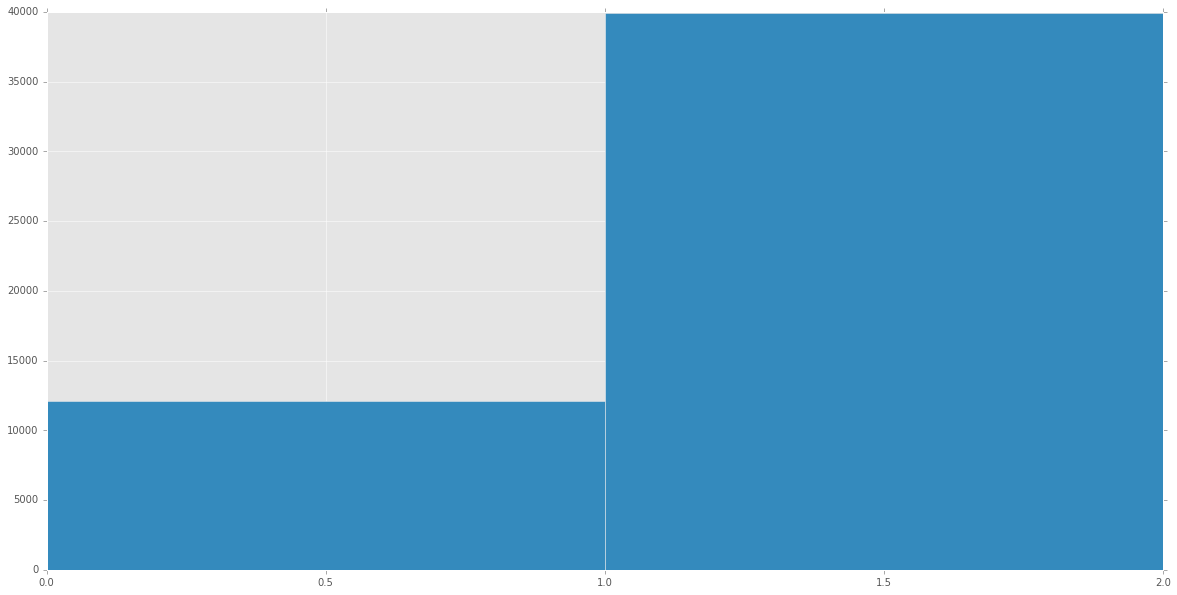

In [13]:
plot_histo(wiki_meta['gender'], bins=(0, 1, 2))

## Analyse IMDb Dataset

In [6]:
if not fs.exists(fs.join(DATA_DIR, IMDB_META_OBJ)):
    # Load the dataset
    imdb_meta = get_meta_data(fs.join(DATA_DIR, IMDB_META_FILE), 'imdb')
    
    # Identify faulty images
    sanity_mask = img_is_sane_vec(list(map(lambda p: fs.join(DATA_DIR, IMDB_CROPS_DIR, p), imdb_meta['path'])))
    
    # We can assume that images with the dimensions (1,1) are faulty
    print('Faulty entries by img dimension: %i' % (len(sanity_mask) - np.sum(sanity_mask)))
    
    # Clean the data set
    imdb_meta = filter_meta_data(imdb_meta, sanity_mask)
    
    # We can assume that ages above 100 are faulty
    print('Faulty entries by age > 100: %i' % (np.sum(imdb_meta['age'] > 100)))
    print('Faulty entries by age < 0: %i' % (np.sum(imdb_meta['age'] < 0)))

    imdb_meta = filter_meta_data(imdb_meta, imdb_meta['age'] <= 100)
    imdb_meta = filter_meta_data(imdb_meta, imdb_meta['age'] >= 0)
    
    with open(fs.join(DATA_DIR, IMDB_META_OBJ), 'wb') as file:
        pickle.dump(imdb_meta, file)
else:
    with open(fs.join(DATA_DIR, IMDB_META_OBJ), 'rb') as file:
        imdb_meta = pickle.load(file)

Faulty entries by img dimension: 0
Faulty entries by age > 100: 160
Faulty entries by age < 0: 493


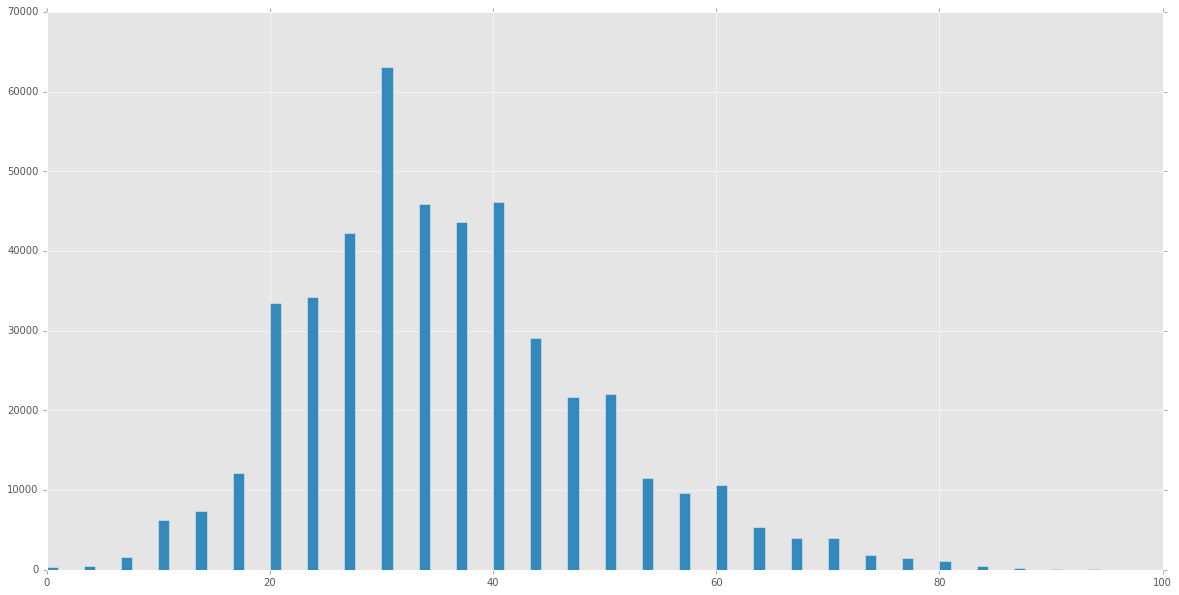

In [7]:
plot_histo(imdb_meta['age'], bins=30)

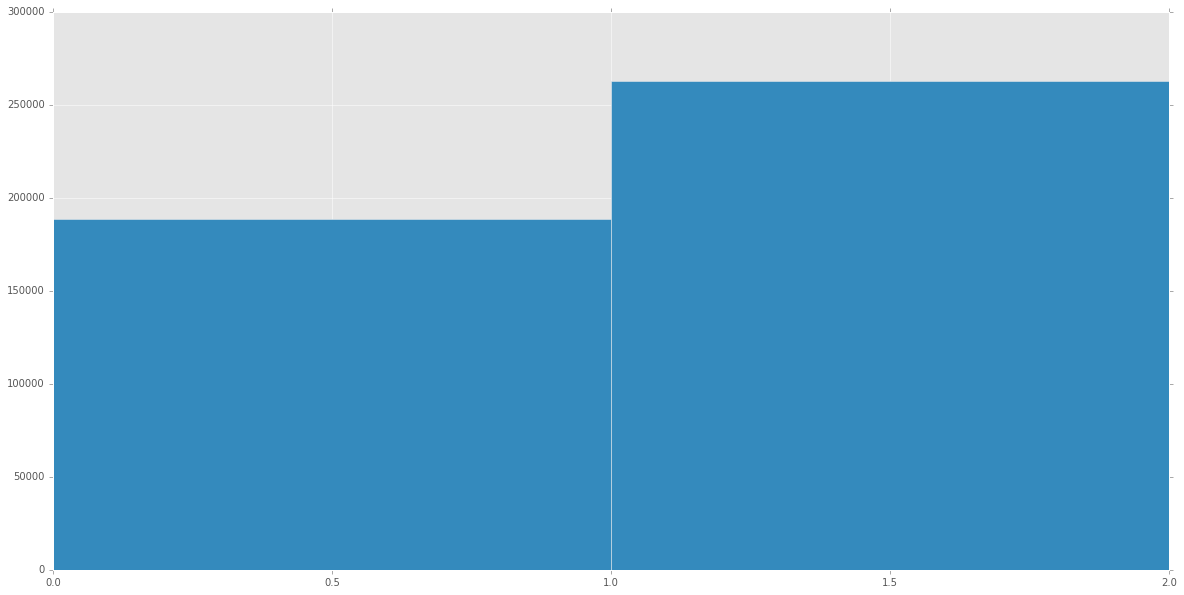

In [12]:
plot_histo(imdb_meta['gender'], bins=(0,1,2))